In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd
%matplotlib inline
from matplotlib import pyplot as plt
import random
import os.path as osp

## Define class and matching index

In [3]:
#label_idx = {'valve': 4, 'backpack': 0, 'extinguisher': 1, 'toolbox': 3, 'radio': 2}
label_idx = {'people': 0}
label_idx = sorted(label_idx.items(), key=lambda kv: kv[1])
label = ['background']
for i in label_idx:
    label.append(i[0])
print(label)
label = ['background', 'people', 'palm']

['background', 'people']


In [13]:
net = build_ssd('test', 300, 2)    # initialize SSD, +1 for background
net.load_weights('./weights/subt_real/subt_real_95.pth')

Loading weights into state dict...
Finished!


## Build SSD300 Network

VOC2007_006698.jpg
torch.Size([1, 2, 200, 5])


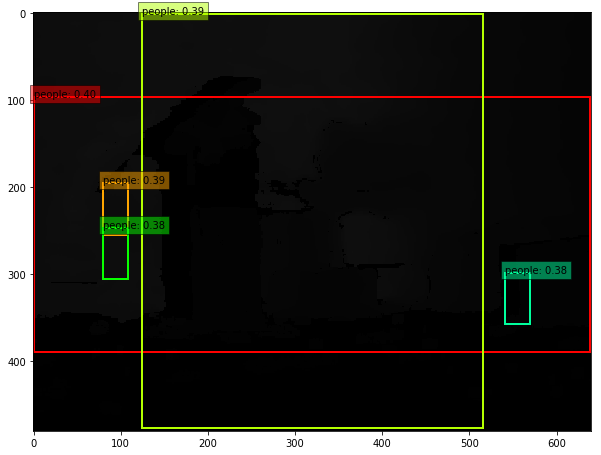

In [16]:
IMAGE_ROOT = "/media/arg_ws3/5E703E3A703E18EB/data/argbot/person/image/"
img_list = os.listdir(IMAGE_ROOT)
#test_file = '/media/arg_ws3/5E703E3A703E18EB/data/subt_artifact/ImageSets/Main/test.txt'
#img_list = []
#for line in open(osp.join(test_file)):
#    img_list.append(line.strip())

img_id = img_list[int(random.randint(0, len(img_list)-1))]
print(img_id)
#img_path = IMAGE_ROOT + '/' + img_list[img_id]
#img_path = IMAGE_ROOT + '/' + img_list[img_id] + '.jpg'
#print(img_id)
#image = cv2.imread(IMAGE_ROOT + img_id)
image = cv2.imread('/media/arg_ws3/5E703E3A703E18EB/data/subt_real_ssd/JPEGImages/scene000001_9.png')
rgb_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
#plt.imshow(rgb_image)
#plt.show()

x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
x = torch.from_numpy(x).permute(2, 0, 1)

xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)
print(y.shape)
currentAxis = plt.gca()
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
detections = y.data # torch.Size([1, 4, 200, 5]) --> [batch?, class, object, coordinates]
objs = []
for i in range(detections.size(1)): # detections.size(1) --> class size
    for j in range(5): # each class choose top 5 predictions
        if detections[0, i, j, 0].cpu().numpy() > 0.2:
            score = detections[0, i, j, 0]
            pt = (detections[0, i, j,1:]*scale).cpu().numpy()
            objs.append([pt[0], pt[1], pt[2]-pt[0]+1, pt[3]-pt[1]+1, i, score])
    color_BBX = (255, 255, 0)
    color_TEXT = (255, 0, 0)
    colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()
    for i, obj in enumerate(objs):
        #cv2.rectangle(rgb_image, (int(obj[0]), int(obj[1])),\
        #            (int(obj[0] + obj[2]), int(obj[1] + obj[3])), color_BBX, 3)
        #cv2.putText(rgb_image, label[obj[4]], (int(obj[0]), int(obj[1])), 0, 1, color_TEXT,2)
        coords = (obj[0], obj[1]), obj[2], obj[3]
        display_txt = '%s: %.2f'%(label[obj[4]], obj[5])
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=colors[i], linewidth=2))
        currentAxis.text(obj[0], obj[1], display_txt, bbox={'facecolor':colors[i], 'alpha':0.5})
plt.imshow(rgb_image)

In [ ]:
torch.Size([1, 2, 200, 5])